# Speaker Diarization Pipeline Test

このノートブックでは、実装した話者分離パイプラインをテストします。

In [ ]:
import sys
import os

# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

from src import (
    PodcastFillersLoader,
    SpeakerDiarizer,
    AudioSeparator,
    StereoAudioGenerator,
    DiarizationPipeline
)
from src.utils import (
    visualize_diarization,
    visualize_stereo_waveform,
    calculate_audio_statistics
)

# Hugging Face token (set as environment variable)
HF_TOKEN = os.getenv('HF_TOKEN')
if not HF_TOKEN:
    print("⚠️ Warning: HF_TOKEN not set. You'll need it for speaker diarization.")
    print("Set it with: export HF_TOKEN='your_token_here'")

## 1. データの確認

In [2]:
# データローダーの初期化
loader = PodcastFillersLoader(data_dir='../data')

# 利用可能なエピソードをリスト
train_episodes = loader.get_episode_list('train')
print(f"Training episodes: {len(train_episodes)}")
print(f"\n最初の5エピソード:")
for i, episode in enumerate(train_episodes[:5], 1):
    print(f"  {i}. {episode}")

Training episodes: 173

最初の5エピソード:
  1. All The Fly Kids_Chaos & Culture Episode 10 Rethinking the Urban Marketing Aesthetic feat. Karim Lateef
  2. All The Fly Kids_Episode 125 The _End is Near_ Episode with Geronimo Knows and Chelle B.
  3. All The Fly Kids_Episode 64 _Places and Spaces I've Been_ with Timothy Anne Burnside of the Smithsonian NMAAHC
  4. Americhicks_10.4.18FBI Report On Kavanaugh-Homeless Urban Camping-Gov. Hickenlooper and Electric Cars
  5. Americhicks_Heart of the Matter September 14th Hour 2


In [3]:
# テスト用エピソードを選択（短いものを選ぶと処理が速い）
test_episode = train_episodes[0]
print(f"テストエピソード: {test_episode}")

# エピソード情報を取得
info = loader.get_episode_info(test_episode, 'train')
print(f"\nエピソード情報:")
for key, value in info.items():
    print(f"  {key}: {value}")

テストエピソード: All The Fly Kids_Chaos & Culture Episode 10 Rethinking the Urban Marketing Aesthetic feat. Karim Lateef



エピソード情報:
  episode_name: All The Fly Kids_Chaos & Culture Episode 10 Rethinking the Urban Marketing Aesthetic feat. Karim Lateef
  split: train
  audio_duration: 3413.8209375
  sample_rate: 16000
  num_annotations: 522
  has_transcript: True
  has_vad: True


## 2. 音声データの読み込み

In [4]:
# 音声を読み込む
audio, sr = loader.load_episode_audio(test_episode, 'train')

print(f"音声読み込み完了:")
print(f"  サンプル数: {len(audio):,}")
print(f"  サンプリングレート: {sr} Hz")
print(f"  継続時間: {len(audio)/sr:.2f}秒 ({len(audio)/sr/60:.2f}分)")

# 最初の10秒を再生
print("\n最初の10秒を再生:")
display(Audio(audio[:sr*10], rate=sr))

音声読み込み完了:
  サンプル数: 54,621,135
  サンプリングレート: 16000 Hz
  継続時間: 3413.82秒 (56.90分)

最初の10秒を再生:


In [11]:
audio

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       9.15527344e-05, 9.15527344e-05, 1.83105469e-04], shape=(54621135,))

## 3. 話者分離のテスト

**注意**: この処理にはHugging Faceトークンが必要です。

In [6]:
# 話者分離器の初期化
print("話者分離器を初期化中...")
diarizer = SpeakerDiarizer(hf_token=HF_TOKEN, device='cpu')
print("✓ 初期化完了")

話者分離器を初期化中...
Loading speaker diarization model: pyannote/speaker-diarization-3.1
Using device: cpu
✓ 初期化完了


In [15]:
import torch

In [25]:
audio_dict = {
            'waveform': torch.from_numpy(audio[:100000]).unsqueeze(0).float(),
            'sample_rate': sr
        }

In [26]:
dearization = diarizer.pipeline(audio_dict)

/home/piro0526/PodcastFillers/.venv/lib/python3.12/site-packages/pyannote/audio/models/blocks/pooling.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)


In [27]:
type(dearization)

pyannote.audio.pipelines.speaker_diarization.DiarizeOutput

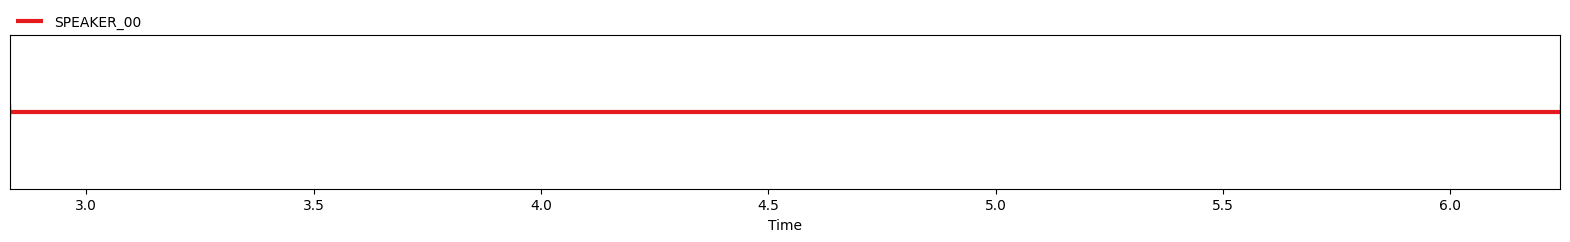

In [ ]:
dearization.speaker_diarization.itertracks

In [11]:
# 話者分離を実行（時間がかかる場合があります）
print("話者分離を実行中...")
print("⚠️ この処理には数分かかる場合があります")

segments = diarizer.diarize(
    audio[:2880000],
    sr,
    min_speakers=2,
    max_speakers=4
)

print(f"\n✓ 話者分離完了")
print(f"検出されたセグメント数: {len(segments)}")

# 最初の10セグメントを表示
print("\n最初の10セグメント:")
for i, seg in enumerate(segments[:10], 1):
    print(f"  {i:2d}. {seg.speaker_id}: {seg.start:.2f}s - {seg.end:.2f}s ({seg.duration():.2f}s)")

話者分離を実行中...
⚠️ この処理には数分かかる場合があります

✓ 話者分離完了
検出されたセグメント数: 77

最初の10セグメント:
   1. SPEAKER_00: 2.90s - 9.09s (6.19s)
   2. SPEAKER_00: 9.60s - 10.21s (0.61s)
   3. SPEAKER_00: 10.92s - 15.54s (4.62s)
   4. SPEAKER_00: 15.69s - 18.34s (2.65s)
   5. SPEAKER_00: 18.90s - 19.56s (0.66s)
   6. SPEAKER_00: 20.13s - 21.12s (1.00s)
   7. SPEAKER_00: 21.43s - 22.88s (1.45s)
   8. SPEAKER_00: 23.25s - 24.36s (1.11s)
   9. SPEAKER_00: 24.74s - 27.27s (2.53s)
  10. SPEAKER_00: 27.60s - 28.13s (0.52s)


In [12]:
# 話者統計
stats = diarizer.get_speaker_statistics(segments)

print("話者統計:")
for speaker_id, speaker_stats in stats.items():
    print(f"\n{speaker_id}:")
    print(f"  総発話時間: {speaker_stats['total_time']:.2f}秒")
    print(f"  セグメント数: {speaker_stats['num_segments']}")
    print(f"  平均セグメント長: {speaker_stats['avg_segment_duration']:.2f}秒")
    print(f"  発話率: {speaker_stats['speaking_ratio']*100:.1f}%")

話者統計:

SPEAKER_00:
  総発話時間: 95.77秒
  セグメント数: 50
  平均セグメント長: 1.92秒
  発話率: 53.2%

SPEAKER_01:
  総発話時間: 54.56秒
  セグメント数: 27
  平均セグメント長: 2.02秒
  発話率: 30.3%


In [13]:
# ロール割り当て
role_mapping = diarizer.assign_roles(segments)

print("ロール割り当て:")
for speaker_id, role in role_mapping.items():
    print(f"  {speaker_id} → {role}")

ロール割り当て:
  SPEAKER_00 → ai
  SPEAKER_01 → user


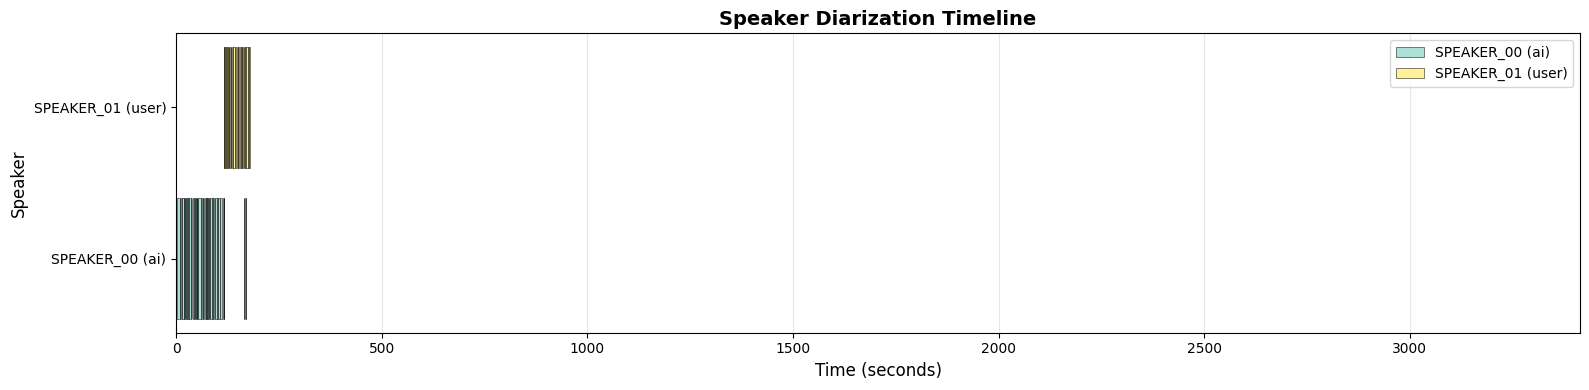

In [14]:
# 話者分離のタイムラインを可視化
duration = len(audio) / sr
fig = visualize_diarization(
    segments,
    duration,
    role_mapping,
    figsize=(16, 4)
)
plt.show()

## 4. 音声分離のテスト

In [15]:
# 音声分離器の初期化
separator = AudioSeparator(fade_duration=0.01)

# 話者ごとに分離
print("音声を話者ごとに分離中...")
separated = separator.separate_by_speaker(audio, segments, sr)
print(f"✓ 分離完了: {len(separated)}人の話者")

# ロールベースのトラックを作成
role_tracks = separator.create_two_speaker_tracks(audio, segments, role_mapping, sr)
print(f"✓ ロールベーストラック作成完了: {list(role_tracks.keys())}")

音声を話者ごとに分離中...
✓ 分離完了: 2人の話者
✓ ロールベーストラック作成完了: ['ai', 'user']


In [17]:
# AI（左チャンネル）の音声を再生
print("AI音声（左チャンネル）の最初の10秒:")
display(Audio(role_tracks['ai'][sr*100:sr*130], rate=sr))

print("\nユーザー音声（右チャンネル）の最初の10秒:")
display(Audio(role_tracks['user'][sr*100:sr*130], rate=sr))

AI音声（左チャンネル）の最初の10秒:



ユーザー音声（右チャンネル）の最初の10秒:


## 5. ステレオ音声の生成

In [18]:
# ステレオジェネレーターの初期化
stereo_gen = StereoAudioGenerator(target_sr=24000)

# ステレオ音声を生成
print("ステレオ音声を生成中（24kHzにリサンプリング）...")
stereo = stereo_gen.create_stereo_from_roles(role_tracks, sr)

print(f"✓ ステレオ音声生成完了")
print(f"  形状: {stereo.shape}")
print(f"  サンプリングレート: {stereo_gen.target_sr} Hz")
print(f"  継続時間: {stereo.shape[1]/stereo_gen.target_sr:.2f}秒")

ステレオ音声を生成中（24kHzにリサンプリング）...
✓ ステレオ音声生成完了
  形状: (2, 81931703)
  サンプリングレート: 24000 Hz
  継続時間: 3413.82秒


In [19]:
# 検証
validation = stereo_gen.validate_stereo(stereo)

print("ステレオ音声の検証:")
print(f"  有効: {validation['valid']}")

if validation['errors']:
    print("  エラー:")
    for error in validation['errors']:
        print(f"    - {error}")

if validation['warnings']:
    print("  警告:")
    for warning in validation['warnings']:
        print(f"    - {warning}")

ステレオ音声の検証:
  有効: True


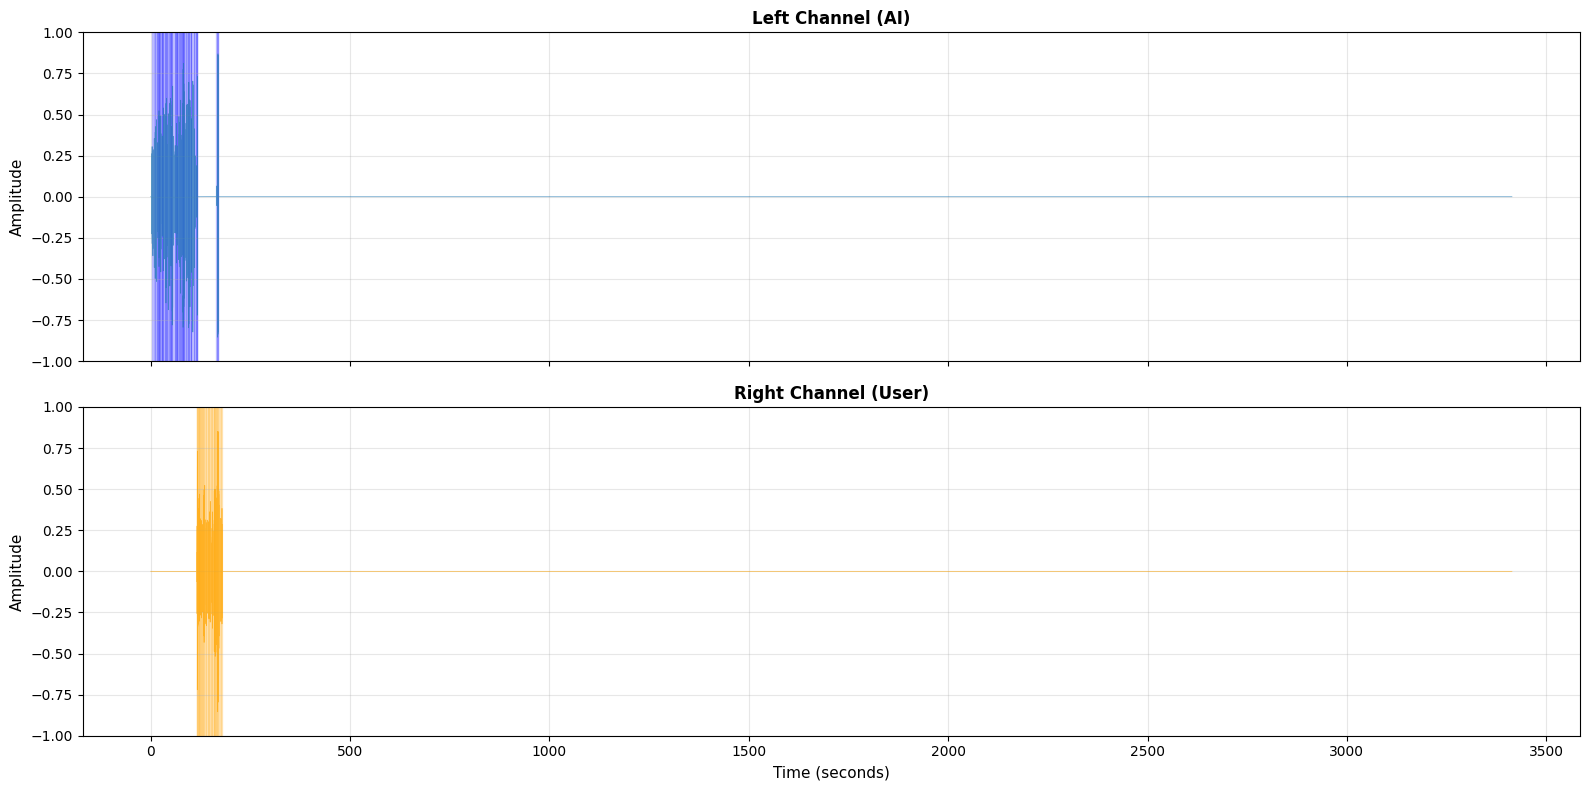

In [20]:
# ステレオ波形の可視化
fig = visualize_stereo_waveform(
    stereo,
    stereo_gen.target_sr,
    segments,
    role_mapping,
    figsize=(16, 8)
)
plt.show()

In [22]:
stereo

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(2, 81931703))

In [23]:
# ステレオ音声の再生（最初の10秒）
print("ステレオ音声の最初の10秒を再生:")
print("（左: AI、右: ユーザー）")
stereo_10s = stereo[:, stereo_gen.target_sr*100:stereo_gen.target_sr*130]
display(Audio(stereo_10s, rate=stereo_gen.target_sr))  # Transpose for Audio widget

ステレオ音声の最初の10秒を再生:
（左: AI、右: ユーザー）


## 6. End-to-Endパイプラインのテスト

In [ ]:
# パイプラインの初期化
print("パイプラインを初期化中...")
pipeline = DiarizationPipeline(
    data_dir='../data',
    output_dir='../outputs',
    hf_token=HF_TOKEN,
    device='auto'
)
print("✓ 初期化完了")

In [ ]:
# エピソードを処理
# 注意: この処理には数分かかります
result = pipeline.process_episode(
    episode_name=test_episode,
    split='train'
)

In [ ]:
# 結果のサマリー
print("\n" + "="*60)
print("処理結果サマリー")
print("="*60)
print(f"エピソード: {result['episode_name']}")
print(f"継続時間: {result['duration']:.2f}秒")
print(f"検出された話者数: {len(result['statistics'])}")
print(f"セグメント数: {len(result['segments'])}")

print(f"\n話者統計:")
for speaker_id, stats in result['statistics'].items():
    role = result['role_mapping'].get(speaker_id, 'unknown')
    print(f"  {speaker_id} ({role}):")
    print(f"    - 発話時間: {stats['total_time']:.2f}秒 ({stats['speaking_ratio']*100:.1f}%)")
    print(f"    - セグメント数: {stats['num_segments']}")

print(f"\n出力ファイル:")
for file_type, path in result['output_paths'].items():
    from pathlib import Path
    from src.utils import get_file_size_mb
    size = get_file_size_mb(path)
    print(f"  {file_type}: {Path(path).name} ({size:.2f} MB)")

## 7. 生成されたファイルの確認

In [ ]:
import soundfile as sf
import json

# 生成されたステレオ音声を読み込む
output_wav_path = result['output_paths']['wav']
stereo_output, sr_output = sf.read(output_wav_path)

print(f"生成されたステレオ音声:")
print(f"  ファイル: {output_wav_path}")
print(f"  形状: {stereo_output.shape}")
print(f"  サンプリングレート: {sr_output} Hz")
print(f"  継続時間: {len(stereo_output)/sr_output:.2f}秒")

# 最初の10秒を再生
print("\n最初の10秒を再生:")
display(Audio(stereo_output[:sr_output*10].T, rate=sr_output))

In [ ]:
# メタデータを確認
metadata_path = result['output_paths']['metadata']
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print("メタデータ:")
print(json.dumps(metadata, indent=2, ensure_ascii=False)[:1000])  # 最初の1000文字

## まとめ

このノートブックでは以下をテストしました：

1. ✅ データローダーでエピソード情報を取得
2. ✅ 音声データの読み込み
3. ✅ pyannote.audioによる話者分離
4. ✅ 話者ごとの音声分離
5. ✅ ステレオ音声の生成（24kHz）
6. ✅ End-to-Endパイプライン
7. ✅ 出力ファイルの確認

### 次のステップ

- バッチ処理で複数エピソードを処理
- 品質評価とエラー分析
- Moshiファインチューニングへの統合